In [111]:
import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks/')

import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None

import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph_leiden
from functions.datamodel import OptimumParameter
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

#from region_filters import columns_eu_unique, columns_non_eu_unique
from optimal_clustering import optimal_clustering

pd.options.mode.chained_assignment = None

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

import warnings
# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from functions.env import DB_SCIENCE_PATH_NEW

In [112]:
# 1-get the jaccard similarity between all the differnet regions and a sampling of the regions of the same size

In [113]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [114]:
"""matrix_baseline = pd.read_csv('../networks/matrix/weighted_optimized_before_1700.csv', index_col = [0])
matrix_baseline= pd.read_csv('../networks/matrix/weighted_non_normalized.csv', index_col = [0])
matrix_baseline = matrix_baseline[['source', 'target', 'weight']]
matrix_baseline['weight'] = (matrix_baseline['weight'] - matrix_baseline['weight'].min()) / (matrix_baseline['weight'].max() - matrix_baseline['weight'].min())"""

"matrix_baseline = pd.read_csv('../networks/matrix/weighted_optimized_before_1700.csv', index_col = [0])\nmatrix_baseline= pd.read_csv('../networks/matrix/weighted_non_normalized.csv', index_col = [0])\nmatrix_baseline = matrix_baseline[['source', 'target', 'weight']]\nmatrix_baseline['weight'] = (matrix_baseline['weight'] - matrix_baseline['weight'].min()) / (matrix_baseline['weight'].max() - matrix_baseline['weight'].min())"

In [115]:
import numpy as np

def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix1.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix1.columns:
            matrix1[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix1.columns:
        matrix1.at[occupation, occupation] = 0.0

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

        # Add the row[i]/col[i] when there is not information
    all_occupations = list(matrix2.index)

    # Add missing occupations
    for occupation in all_occupations:
        if occupation not in matrix2.columns:
            matrix2[occupation] = 0.0  # Add new column with zeros

    # Resetting the diagonal values to 0 for existing occupations (if necessary)
    for occupation in matrix2.columns:
        matrix2.at[occupation, occupation] = 0.0

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity

In [116]:
dataset_average =  pd.read_csv('edges_list_filtered/average_edges_list.csv', index_col = [0])


df_edges_regions = pd.read_csv('../networks/data/global_before_1700.csv', index_col = [0])
df_edges_regions['meta_occupation']=df_edges_regions['meta_occupation'].apply(lambda x : x.split(' | '))
df_edges_regions = df_edges_regions.explode('meta_occupation')
df_edges_regions = df_edges_regions.reset_index(drop=True)

In [117]:
regions_edge_list = {}
final_list = []
for region in df_edges_regions.region_name.unique():

    df_sample = df_edges_regions[df_edges_regions['region_name']==region]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    df_net = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()
    regions_edge_list[region] = df_edge_filter # to compute the pairwise distance between regions
    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('score', ascending=False)
    

100%|██████████| 21/21 [00:17<00:00,  1.17it/s]


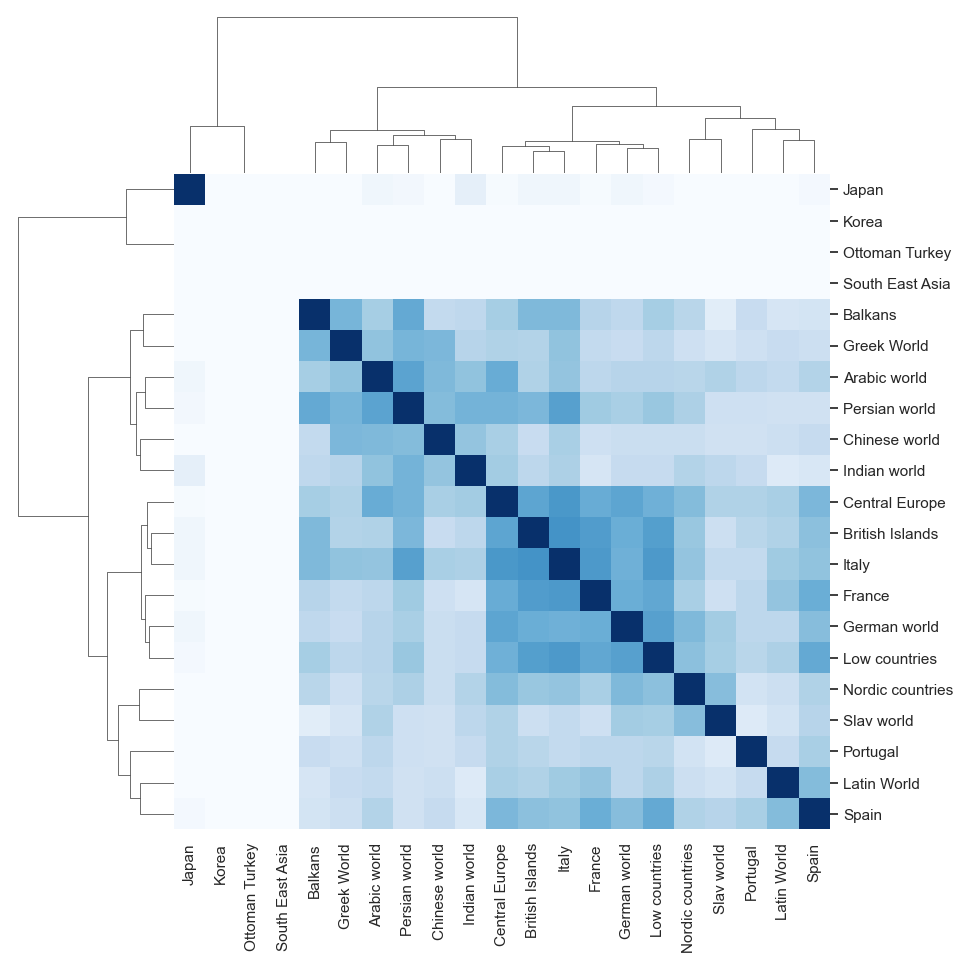

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in tqdm(regions_edge_list.items()):
    for dataset2_name, dataset2 in regions_edge_list.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
matrix_df = matrix_df.astype(float)

# Create a hierarchical clustered heatmap using seaborn.clustermap
sns.set(font_scale=1.0)
clustered_heatmap = sns.clustermap(
    matrix_df,
    cmap='Blues',
    annot=False,
    fmt=".2f",
    cbar_kws={"orientation": "horizontal", "label": None},  # Hide the color bar (legend)
    method='ward'
)
clustered_heatmap.ax_heatmap.set_ylabel('')  # Set y-label to an empty string
clustered_heatmap.ax_heatmap.set_xlabel('')  # Set y-label to an empty string
clustered_heatmap.cax.set_visible(False)

# Customize the appearance of the clustermap
plt.title('Hierarchical Clustering and Similarity')

# Show the plot
plt.show()

In [119]:
""""min_individuals = 0

final_list = []
for region in list(set(df_regions['region_name'])):
    print(region)
#for region in ['Japan']:

    df_sample = df_regions[df_regions['region_name']==region]


    # count number of individuals with at least two occupations
    count_duplicate = df_sample[df_sample['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region)

    if duplicate_counts <min_individuals:
        continue
        
 

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    if len(set(df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())

    matrix1, matrix2 = prepare_edge_list(df_edge, matrix_baseline)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('score', ascending=False)"""

'"min_individuals = 0\n\nfinal_list = []\nfor region in list(set(df_regions[\'region_name\'])):\n    print(region)\n#for region in [\'Japan\']:\n\n    df_sample = df_regions[df_regions[\'region_name\']==region]\n\n\n    # count number of individuals with at least two occupations\n    count_duplicate = df_sample[df_sample[\'region_code\']==region]\n    duplicate_counts = count_duplicate[\'wikidata_id\'].value_counts()\n    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])\n\n    print(region)\n\n    if duplicate_counts <min_individuals:\n        continue\n        \n \n\n    df_sample = df_sample[[\'wikidata_id\', \'meta_occupation\']].copy()\n    len_individuals = len(set(df_sample[\'wikidata_id\']))\n    df_sample.columns = ["source", "target"]\n    df_sample["weight"] = 1\n\n    # Draw the graph\n    df_sample = pl.from_pandas(df_sample)\n    df_edge, df_nodes = get_edge_node_table(df_sample)\n\n    if len(set(df_edge[\'weight\']))!=1:\n        df_edge[\'weight\'] = (df_e

Display the distance, add a regresion line and add labels

## plot with labels

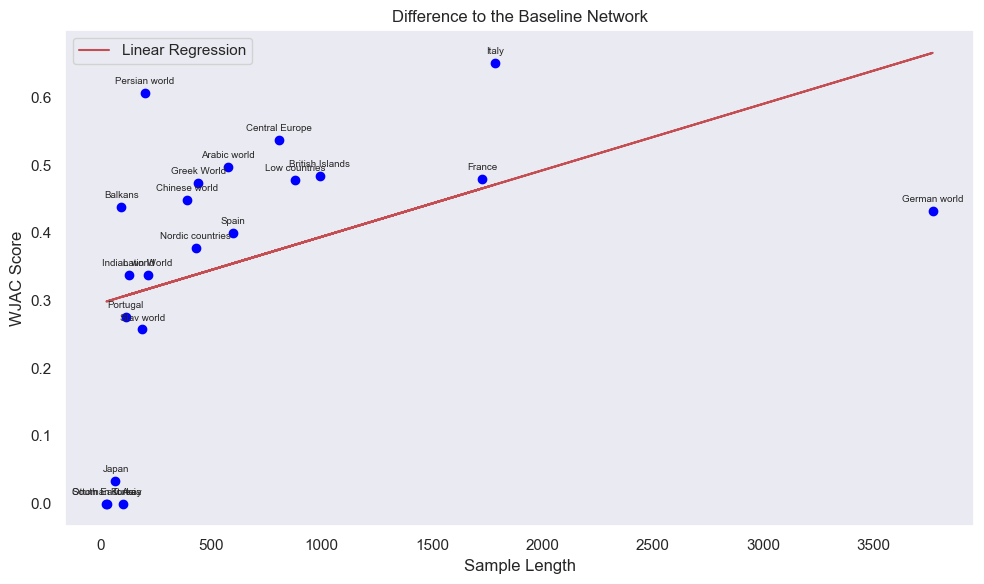

In [120]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

df = pd.DataFrame({
    'sample_length': final_df['sample_length'],
    'score': final_df['score'],
    'region': final_df['region']
})



fig, ax = plt.subplots(figsize=(10, 6))


ax.scatter(df['sample_length'], df['score'], color='blue')

for i, row in df.iterrows():
    ax.text(row['sample_length'], row['score']+0.01, row['region'], 
            fontsize=7, ha='center', va='bottom')

X = df[['sample_length']]
y = df['score']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
p_value = model.pvalues[1]
y_pred = model.predict(X)

ax.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

ax.legend()
ax.set_xlabel('Sample Length')
ax.set_ylabel('WJAC Score')
ax.set_title('Difference to the Baseline Network')
ax.grid(False)

fig.tight_layout()
plt.show()

In [121]:
df_edges_regions

,wikidata_id,individual_name,region_code,region_name,birthyear,meta_occupation,meta_region
0,Q316119,Gnaeus Pompeius Trogus,re_latin,Latin World,-100.0,historian,antiquity
1,Q782074,Claudianus Mamertus,re_latin,Latin World,420.0,theologian,antiquity
2,Q782074,Claudianus Mamertus,re_latin,Latin World,420.0,philosopher,antiquity
3,Q182123,Irenaeus,re_latin,Latin World,130.0,theologian,antiquity
4,Q182123,Irenaeus,re_latin,Latin World,130.0,philosopher,antiquity
...,...,...,...,...,...,...,...
17543,Q11362,Avempace,re_arabic_world,Arabic world,1080.0,philosopher,non_europe
17544,Q11362,Avempace,re_arabic_world,Arabic world,1080.0,mathematician,non_europe
17545,Q1243803,George Elmacin,re_arabic_world,Arabic world,1223.0,historian,non_europe
17546,Q18397639,Mūsá ibn ʻUqbah,re_arabic_world,Arabic world,674.0,historian,non_europe


In [122]:

final_list = []
list_individuals = list(set(df_edges_regions.wikidata_id))
for region in list(set(df_edges_regions['region_code'])):
    df_region_filter = df_edges_regions[df_edges_regions['region_code']==region]
    len_ind_region = len(set(df_region_filter['wikidata_id']))
    

    # count number of individuals with at least two occupations
    count_duplicate = df_region_filter[df_region_filter['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region, duplicate_counts)

    random.seed(42)
    list_individuals_sample = random.sample(list_individuals, len_ind_region)
    df_sample = df_edges_regions[df_edges_regions['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))


    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

    """if len(set(df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())"""
    
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'region':region})


final_df_sample = pd.DataFrame(final_list)

final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'score':'score_sample', 'region':'region_sample'})
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')


re_slav_world 36
re_portugal 19
re_chinese_world 70
re_persian_world 54
re_indian_world 23
re_south_east_asia 4
re_german_world 502
re_british_islands 198
re_korea 0
re_ottoman_turkey 2
re_france 321
re_greek_world 442
re_arabic_world 122
re_balkans 15
re_central_europe 139
re_latin 215
re_low_countries 161
re_nordic_countries 77
re_italy 324
re_spain 79
re_japan 5


#### Plot Both

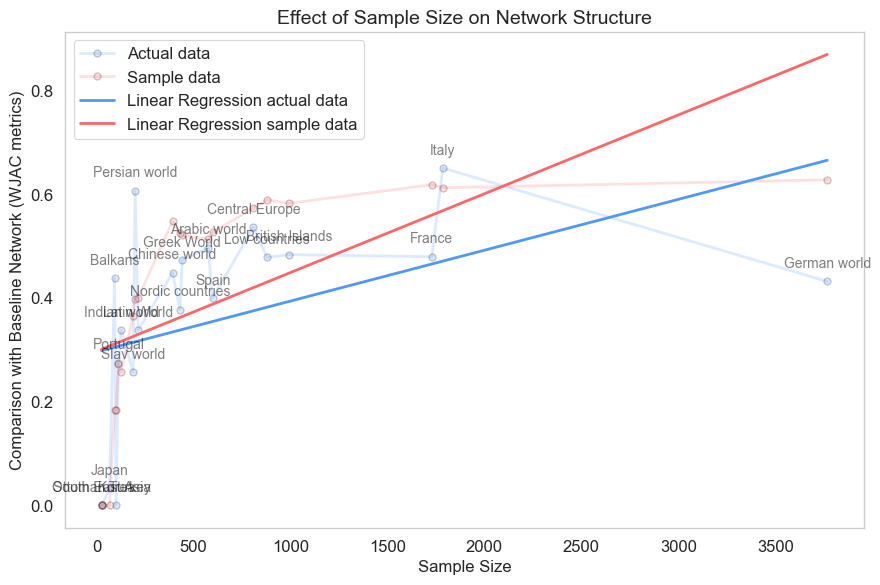

In [123]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['score']
ari_sample_values = df_plot['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network (WJAC metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Network Structure', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['sample_length'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}*)"])

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

### Plot the logs

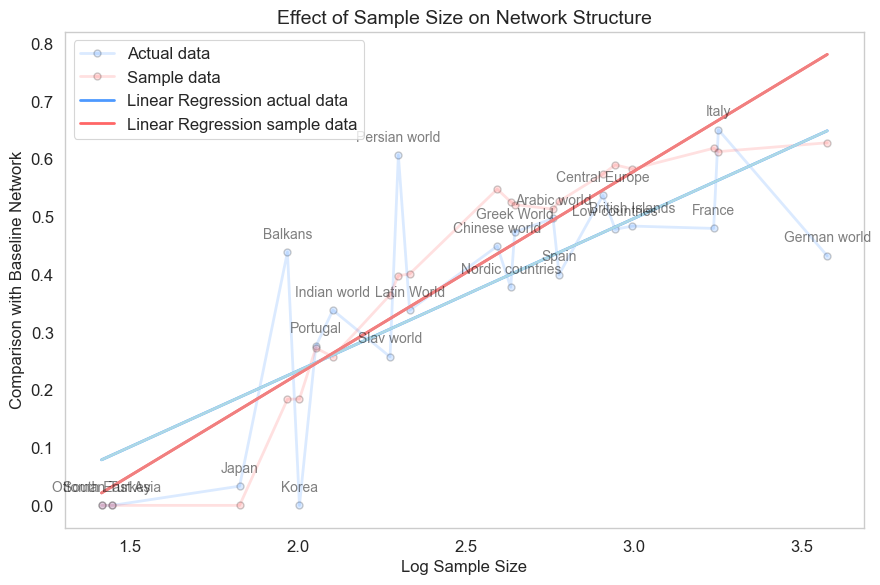

In [124]:
df_plot[['score', 'score_sample']].corr()

# Extracting data from the DataFrame
sample_length = np.log10(df_plot['sample_length'])
ari = df_plot['score']
ari_sample = df_plot['score_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']
df_plot['log_size'] = np.log10(df_plot['sample_length'])

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['score_sample'], label='score_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('Effect of Sample Size on Network Structure', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['log_size'], df_plot['score'], df_plot['score_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

    
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

# Get coefficients instead of p-values
coeff_1 = round(model.params[1], 3)
coeff_2 = round(model_2.params[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model.predict(X), color='lightblue', label=f'Linear Regression (Coeff: {coeff_1})', linewidth=2)
plt.plot(df_plot['log_size'], model_2.predict(X), color='lightcoral', label=f'Linear Regression (Coeff: {coeff_2})', linewidth=2)


ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                            #f'Linear Regression (Coeff: {coeff_1})',
                                            #f'Linear Regression (Coeff: {coeff_2})'])

plt.tight_layout()
plt.show()


In [125]:
df_plot[['score', 'score_sample']].corr()

,score,score_sample
score,1.000000,0.845647
score_sample,0.845647,1.000000


### Baseline Century

In [126]:
df_time = df_edges_regions.copy()
df_time['time'] = df_time['birthyear'].apply(lambda year: round(year, -2))
df_time = df_time[['wikidata_id', 'meta_occupation', 'time']].copy()
df_time

,wikidata_id,meta_occupation,time
0,Q316119,historian,-100.0
1,Q782074,theologian,400.0
2,Q782074,philosopher,400.0
3,Q182123,theologian,100.0
4,Q182123,philosopher,100.0
...,...,...,...
17543,Q11362,philosopher,1100.0
17544,Q11362,mathematician,1100.0
17545,Q1243803,historian,1200.0
17546,Q18397639,historian,700.0


In [127]:
final_list = []
#for time in [600]:
for time in sorted(list(set(df_time.time))):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    

    """
     # count number of individuals with at least two occupations
    duplicate_counts = df_sample['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    len_individuals = len(set(df_sample['wikidata_id']))
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())


    """if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    """
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log10(final_df_time['sample_length']+1)
final_df_time

,sample_length,score,time,log_size
0,1,0.000000,-800.0,0.301030
1,3,0.000000,-700.0,0.602060
2,20,0.412945,-600.0,1.322219
3,59,0.267577,-500.0,1.778151
4,98,0.464906,-400.0,1.995635
5,63,0.481049,-300.0,1.806180
6,59,0.363577,-200.0,1.778151
7,57,0.434703,-100.0,1.763428
8,66,0.296093,0.0,1.826075
9,80,0.530661,100.0,1.908485


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


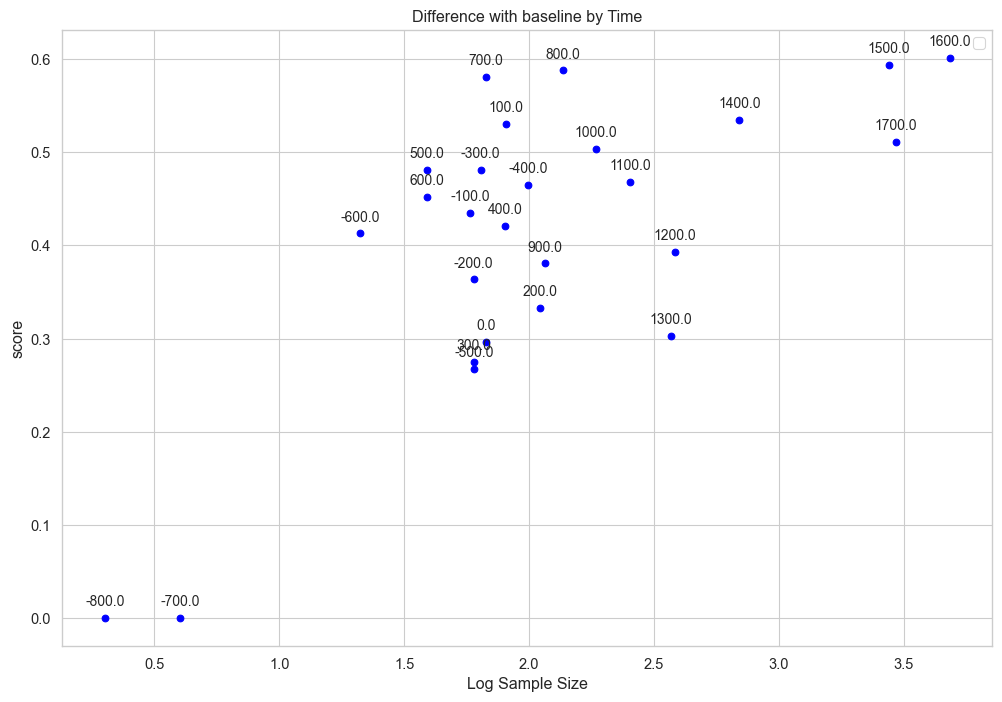

<Figure size 640x480 with 0 Axes>

In [128]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['score']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('score')
plt.title('Difference with baseline by Time')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [129]:
import random

list_individuals = list(set(df_time.wikidata_id))

final_list = []
for time in list(set(df_time['time'])):


    df_time_filter = df_time[df_time['time']==time]
    len_ind_time = len(set(df_time_filter['wikidata_id']))
    
    """
    
        # count number of individuals with at least two occupations
    duplicate_counts = df_time_filter['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue
        
    """

    random.seed(42)
    list_individuals_sample = random.sample(list_individuals, len_ind_time)
    df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    len_individuals = len(set(df_sample['wikidata_id']))

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)


    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    dataset1 = df_edge_filter.copy()
    dataset2 = dataset_average.copy()

    dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
    dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

    """ if len(set( df_edge['weight']))!=1:
        df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    """
    matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
    matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()
    score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
    final_list.append({'sample_length':len_individuals, 'score':score, 'time':time})

final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('sample_length')

final_df_time_sample = final_df_time_sample.rename(columns = {'score':'score_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])

df_plot_sample['log_size'] = np.log10(df_plot_sample['sample_length']+1)
df_plot_sample = df_plot_sample[df_plot_sample['sample_length']>10]

Plot the T statistics

In [130]:

ari_values = df_plot_sample['score']
ari_sample_values = df_plot_sample['score_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

7.0823447631947

In [131]:
df_plot_sample[['score_sample', 'score']].corr()

,score_sample,score
score_sample,1.000000,0.425695
score,0.425695,1.000000


0.0087
1e-05


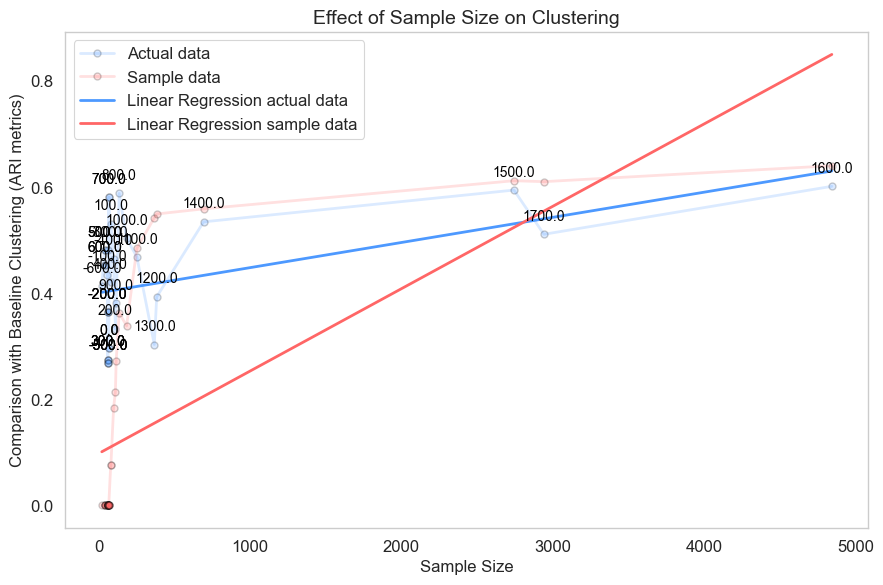

In [132]:
# Extracting data from the DataFrame
sample_length = df_plot_sample['sample_length']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score'], label='score', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['sample_length'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['sample_length']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['sample_length'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])




plt.tight_layout()
# Show the plot
plt.show()

0.00993
0.0


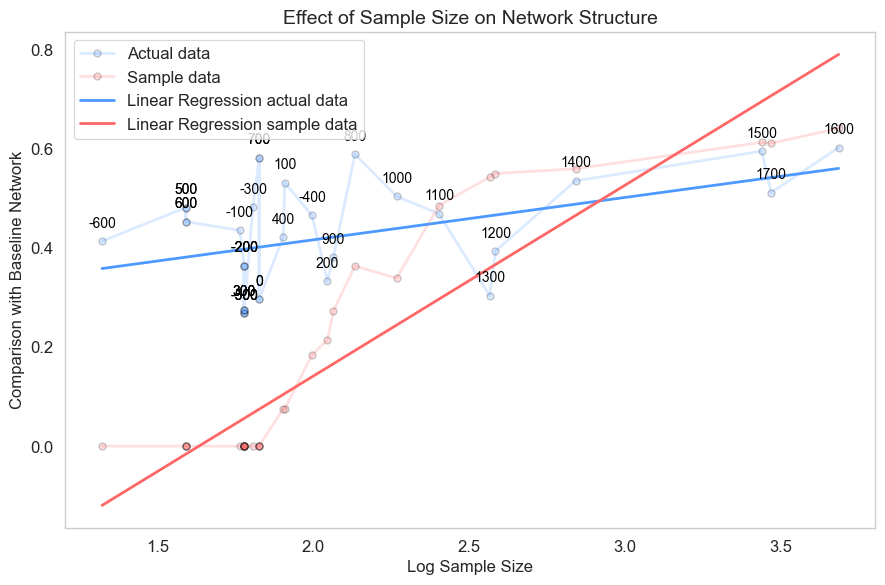

In [133]:
df_plot_sample['time'] = df_plot_sample['time'].astype(int)

import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style

# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['score']
ari_sample = df_plot_sample['score_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['score_sample'], label='score_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Network', fontsize=12)
ax.set_title('Effect of Sample Size on Network Structure', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['score'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['log_size']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)


model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['log_size'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ]) 
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

In [134]:
df_plot_sample[['score_sample','score']].corr()

,score_sample,score
score_sample,1.000000,0.425695
score,0.425695,1.000000
